In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!mkdir train
!cp train.zip train/
!unzip train/train.zip -d train

!mkdir test
!cp test.zip test/
!rm train.zip test.zip
!unzip test/test.zip -d test
!rm train/train.zip
!rm test/test.zip

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras import models, layers 
from keras import callbacks
from keras.applications import Xception
import cv2
import time
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
!ls 

car_clf.h5  drive	 sample_submission.csv	test.csv  train_chop
class.csv   sample_data  test			train	  train.csv


In [0]:
# !rm -r /content/train_chop

In [0]:
train_df = pd.read_csv('train.csv')
train_df.head()
train_df['class'] = train_df['class'].astype(str)

In [0]:
img = cv2.imread(f'/content/train/{train_df.iloc[0, 0]}')

In [6]:
img.shape

(500, 700, 3)

In [0]:
def chop_img(data_type, path_df, margin = 15):
  """
     ex) chip_img('trian', train_df, margin = 20)
     
     data_type = train or test as string         
     path_df = train_df or test_df,
     marging = how many pixel left over 
     
     this function create directory as data_type_chop """
  
  if f'{data_type}_chop' in os.listdir('/content/'):
    os.removedirs(f'{data_type}_chop')
  else:
    os.mkdir(f'{data_type}_chop')                                            # make directory
    
  for i in range(len(path_df.img_file)):
    img = cv2.imread(f'/content/{data_type}/{path_df.iloc[i, 0]}')               # load image
    cv2.waitKey(0)
    
    crop_img = img[path_df.iloc[i, 2] : path_df.iloc[i, 4],     # y : y + h
                   path_df.iloc[i,1] : path_df.iloc[i, 3]]     # x : x + w

    cv2.imwrite(f'/content/{data_type}_chop/{path_df.iloc[i,0]}', crop_img)  # save the image
    
    cv2.waitKey(0)

In [0]:
chop_img('train', train_df)

In [0]:
y = train_df['class']
x = train_df.drop('class', axis = 1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1228, stratify = y)

In [0]:
train_set = pd.concat([X_train, y_train], axis = 1)

In [0]:
validation_set = pd.concat([X_test, y_test], axis=1)

In [9]:
print(train_df.shape)
print('-----------------')
print(train_set.shape)
print(validation_set.shape)

(10016, 6)
-----------------
(8012, 6)
(2004, 6)


In [15]:
train_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
8706,train_08707.jpg,8,42,493,256,90
3986,train_03987.jpg,45,89,610,426,148
7423,train_07424.jpg,90,177,659,425,35
7413,train_07414.jpg,17,33,389,281,88
625,train_00626.jpg,45,83,590,452,65


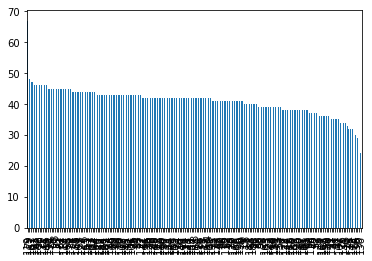

In [19]:
train_set['class'].value_counts().plot(kind='bar')

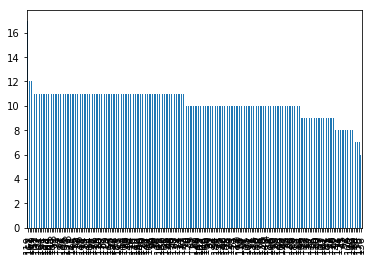

In [21]:
validation_set['class'].value_counts().plot(kind='bar')

In [0]:
train_gen = image.ImageDataGenerator(rescale = 1./255)

validation_gen = image.ImageDataGenerator(rescale = 1./255)

In [0]:
train_data = train_gen.flow_from_dataframe(train_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical',batch_size=64)

valid_data = validation_gen.flow_from_dataframe(validation_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical', batch_size=64)

Found 8012 validated image filenames belonging to 196 classes.
Found 2004 validated image filenames belonging to 196 classes.


In [0]:
xception_model = Xception(include_top = False, 
                          input_shape = (150, 150, 3))

W0630 11:37:41.188322 139818974754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 11:37:41.194524 139818974754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 11:37:41.231856 139818974754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 11:37:41.233082 139818974754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0630 11:37:41.854407 139818974754688 depre

In [0]:
model_ex = models.Sequential()
model_ex.add(xception_model)
model_ex.add(layers.AvgPool2D(2,2, name = 'Avg_pool'))
model_ex.add(layers.Flatten(name = 'Flat'))
model_ex.add(layers.Dense(2048, activation = 'relu', name = 'Dense_1'))
model_ex.add(layers.Dense(196, activation = 'softmax', name = 'Dense_out'))

model_ex.summary()

W0630 11:37:56.163968 139818974754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
Avg_pool (AveragePooling2D)  (None, 2, 2, 2048)        0         
_________________________________________________________________
Flat (Flatten)               (None, 8192)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
Dense_out (Dense)            (None, 196)               401604    
Total params: 38,042,348
Trainable params: 37,987,820
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
model_ex.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

W0630 11:37:58.968209 139818974754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
check_points = callbacks.ModelCheckpoint('car_clf.h5', monitor = 'val_loss', save_best_only=True)

In [0]:
exception_net_history = model_ex.fit_generator(train_data, steps_per_epoch= 8013//64, epochs = 100, validation_data=valid_data, validation_steps=2003//64, callbacks=[check_points])

W0630 11:38:03.677215 139818974754688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
125/125 [==============================] - 174s 1s/step - loss: 5.3330 - acc: 0.0069 - val_loss: 5.2768 - val_acc: 0.0086
Epoch 2/100
125/125 [==============================] - 160s 1s/step - loss: 5.2838 - acc: 0.0093 - val_loss: 8.5392 - val_acc: 0.0082
Epoch 3/100
125/125 [==============================] - 158s 1s/step - loss: 5.1934 - acc: 0.0136 - val_loss: 5.7347 - val_acc: 0.0149
Epoch 4/100
125/125 [==============================] - 158s 1s/step - loss: 4.9991 - acc: 0.0189 - val_loss: 5.7591 - val_acc: 0.0222
Epoch 5/100
125/125 [==============================] - 159s 1s/step - loss: 4.3835 - acc: 0.0349 - val_loss: 4.8746 - val_acc: 0.0448
Epoch 6/100
125/125 [==============================] - 158s 1s/step - loss: 3.6814 - acc: 0.0801 - val_loss: 4.0027 - val_acc: 0.0778
Epoch 7/100
125/125 [==============================] - 158s 1s/step - loss: 3.0041 - acc: 0.1697 - val_loss: 3.9860 - val_acc: 0.1227
Epoch 8/100
125/125 [==============================] - 158s 1s

KeyboardInterrupt: ignored

In [0]:
train_gen = image.ImageDataGenerator(rescale = 1./255, rotation_range = 30, 
                                     width_shift_range = 0.2, 
                                     height_shift_range=0.2, 
                                     shear_range = 0.2, 
                                     zoom_range = 0.2, 
                                     horizontal_flip = True,
                                     vertical_flip = True                                   
                                    )

validation_gen = image.ImageDataGenerator(rescale = 1./255)

In [23]:
train_data = train_gen.flow_from_dataframe(train_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical',batch_size=64)

valid_data = validation_gen.flow_from_dataframe(validation_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical', batch_size=64)

Found 8012 validated image filenames belonging to 196 classes.
Found 2004 validated image filenames belonging to 196 classes.


In [24]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8012 entries, 8706 to 6436
Data columns (total 6 columns):
img_file    8012 non-null object
bbox_x1     8012 non-null int64
bbox_y1     8012 non-null int64
bbox_x2     8012 non-null int64
bbox_y2     8012 non-null int64
class       8012 non-null object
dtypes: int64(4), object(2)
memory usage: 438.2+ KB


In [0]:
train_gen = image.ImageDataGenerator(rescale = 1./255,
                                     rotation_range=30, 
                                     width_shift_range = 0.2, 
                                     height_shift_range=0.2, 
                                     shear_range = 0.2, 
                                     zoom_range = 0.2, 
                                     horizontal_flip = True,
                                     vertical_flip = True,                                  
                                    )

validation_gen = image.ImageDataGenerator(rescale = 1./255)

In [0]:
datagen = image.ImageDataGenerator(rotation_range = 40,
                             height_shift_range = 0.2, 
                             shear_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True,
                             )

In [42]:
plt.imread('/content/train_chop/train_00001.jpg')

array([[[203, 213, 222],
        [206, 216, 225],
        [200, 210, 219],
        ...,
        [101, 115, 115],
        [ 96, 110, 110],
        [ 90, 104, 104]],

       [[198, 209, 215],
        [190, 201, 207],
        [177, 188, 194],
        ...,
        [ 67,  81,  81],
        [ 65,  79,  79],
        [ 61,  75,  75]],

       [[185, 196, 202],
        [178, 189, 195],
        [170, 181, 187],
        ...,
        [ 49,  63,  63],
        [ 48,  62,  62],
        [ 48,  62,  62]],

       ...,

       [[ 56,  74,  74],
        [ 53,  71,  71],
        [ 44,  60,  60],
        ...,
        [ 39,  60,  63],
        [ 39,  60,  63],
        [ 62,  83,  86]],

       [[ 63,  79,  79],
        [ 56,  72,  72],
        [ 43,  59,  59],
        ...,
        [ 62,  83,  86],
        [ 72,  93,  96],
        [ 86, 107, 110]],

       [[ 78,  92,  93],
        [ 72,  86,  87],
        [ 61,  75,  76],
        ...,
        [ 80, 101, 104],
        [ 95, 116, 119],
        [ 97, 118, 121]]

In [0]:
image_chop_test = image.load_img('/content/train_chop/train_00001.jpg', target_size = (150,150))

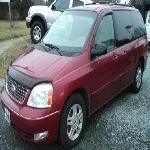

In [46]:
image_chop_test

In [47]:
image.img_to_array(image_chop_test)

array([[[177., 188., 194.],
        [181., 188., 196.],
        [212., 223., 229.],
        ...,
        [ 54.,  66.,  66.],
        [ 60.,  74.,  74.],
        [ 67.,  81.,  81.]],

       [[177., 188., 194.],
        [198., 205., 213.],
        [202., 211., 218.],
        ...,
        [ 42.,  56.,  57.],
        [ 41.,  55.,  56.],
        [ 44.,  58.,  59.]],

       [[ 39.,  50.,  52.],
        [ 35.,  43.,  46.],
        [ 28.,  36.,  39.],
        ...,
        [ 39.,  53.,  56.],
        [ 41.,  55.,  58.],
        [ 40.,  55.,  58.]],

       ...,

       [[ 58.,  76.,  80.],
        [ 83., 101., 103.],
        [ 56.,  72.,  72.],
        ...,
        [ 63.,  84.,  87.],
        [ 46.,  67.,  70.],
        [ 52.,  73.,  76.]],

       [[ 53.,  71.,  73.],
        [ 79.,  94.,  97.],
        [ 97., 111., 112.],
        ...,
        [154., 175., 178.],
        [ 75.,  96.,  99.],
        [ 52.,  73.,  76.]],

       [[ 43.,  59.,  59.],
        [ 64.,  80.,  80.],
        [ 99., 1

In [49]:
train_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
8706,train_08707.jpg,8,42,493,256,90
3986,train_03987.jpg,45,89,610,426,148
7423,train_07424.jpg,90,177,659,425,35
7413,train_07414.jpg,17,33,389,281,88
625,train_00626.jpg,45,83,590,452,65


In [0]:
datagen = image.ImageDataGenerator(rescale=1./255,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2, 
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  shear_range=0.2)

Found 8012 validated image filenames belonging to 196 classes.
(array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.    

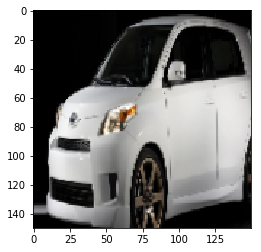

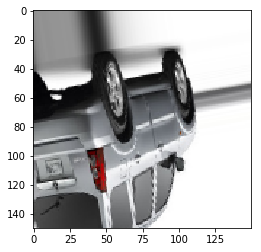

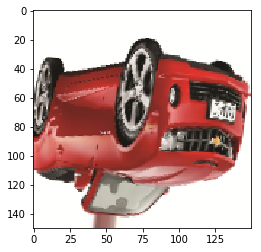

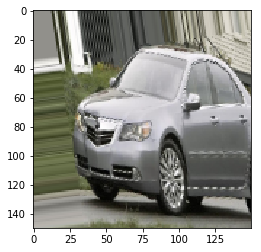

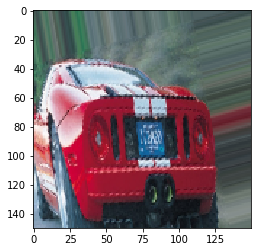

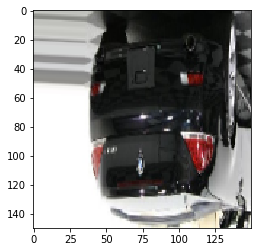

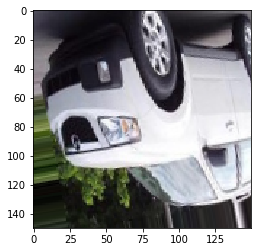

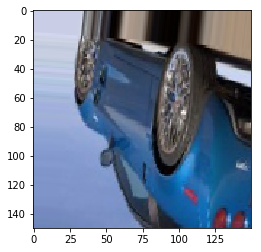

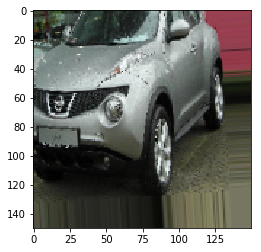

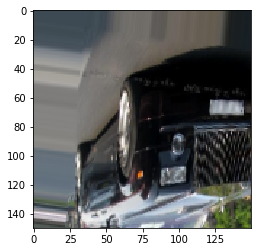

In [102]:
k = 0
for i in datagen.flow_from_dataframe(train_set, '/content/train_chop', x_col='img_file', y_col='class', target_size=(150,150), class_mode='categorical', batch_size=1):
  print(i)
  print(i[0].shape)
  plt.figure(k)
  image_data = i[0].reshape(150,150,3)
  image_data_array = image.array_to_img(image_data)
  imgplot = plt.imshow(image_data_array)
  
  k += 1
  if k % 10 == 0:
    break
   

Found 2004 validated image filenames belonging to 196 classes.
(array([[[[0.13725491, 0.10196079, 0.10588236],
         [0.09411766, 0.10588236, 0.0627451 ],
         [0.10588236, 0.07450981, 0.13333334],
         ...,
         [0.7843138 , 0.87843144, 0.87843144],
         [0.78823537, 0.882353  , 0.882353  ],
         [0.79215693, 0.8862746 , 0.8862746 ]],

        [[0.06666667, 0.04313726, 0.05882353],
         [0.0509804 , 0.06666667, 0.01176471],
         [0.08235294, 0.0627451 , 0.09019608],
         ...,
         [0.79215693, 0.8862746 , 0.8862746 ],
         [0.78823537, 0.882353  , 0.882353  ],
         [0.78823537, 0.882353  , 0.882353  ]],

        [[0.07843138, 0.07058824, 0.09019608],
         [0.06666667, 0.07450981, 0.02352941],
         [0.01568628, 0.01176471, 0.00392157],
         ...,
         [0.78823537, 0.89019614, 0.87843144],
         [0.7843138 , 0.8862746 , 0.8745099 ],
         [0.7843138 , 0.8862746 , 0.8745099 ]],

        ...,

        [[0.81568635, 0.6392

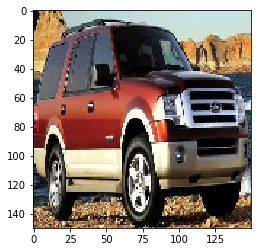

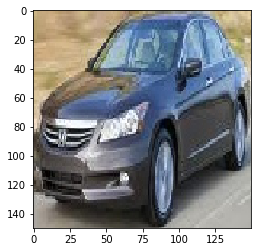

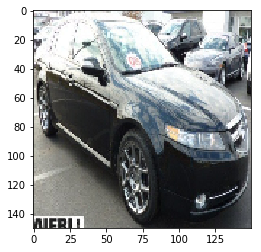

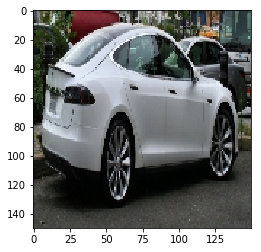

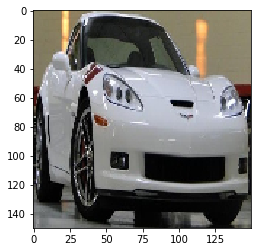

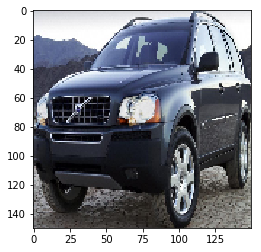

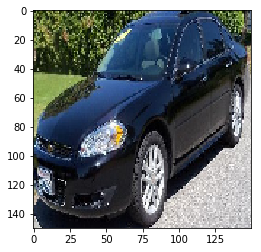

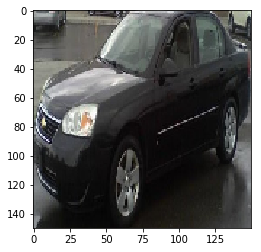

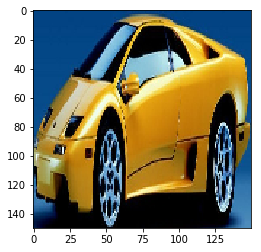

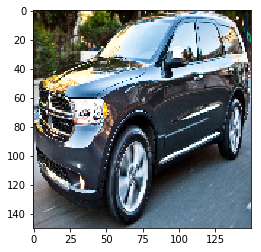

In [104]:
k = 0
for i in validation_gen.flow_from_dataframe(validation_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical', batch_size=1):
  print(i)
  print(i[0].shape)
  plt.figure(k)
  image_data = i[0].reshape(150,150,3)
  image_data_array = image.array_to_img(image_data)
  imgplot = plt.imshow(image_data_array)
  
  k += 1
  if k % 10 == 0:
    break

In [13]:
train_data = datagen.flow_from_dataframe(train_set, '/content/train_chop', x_col='img_file', y_col='class', target_size=(224,224), class_mode='categorical', batch_size=64)
valid_data = validation_gen.flow_from_dataframe(validation_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(224,224), class_mode='categorical', batch_size=64)

Found 8012 validated image filenames belonging to 196 classes.
Found 2004 validated image filenames belonging to 196 classes.


In [135]:
i = 0
for batch in train_data:
  img_array = batch[0]
  print(img_array.shape)
  print(img_array[i])
  for j in range(len(batch[0])):
    plt.figure(j)
    plt.imshow(img_array[j])
    
  i += 1
  if i % 5:
    break

Output hidden; open in https://colab.research.google.com to view.

In [14]:
xception_model = Xception(include_top = False, 
                          input_shape = (224, 224, 3))

W0701 05:31:15.123953 140066814162816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 05:31:15.149027 140066814162816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 05:31:15.154054 140066814162816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 05:31:15.177473 140066814162816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 05:31:15.180443 1400668141

In [138]:
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [15]:
model_ex = models.Sequential()
model_ex.add(xception_model)
model_ex.add(layers.AveragePooling2D((2,2), name = 'Avg_pool'))
model_ex.add(layers.Flatten(name = 'Flat'))
model_ex.add(layers.Dense(2048, activation = 'relu', name = 'Dense_1'))
model_ex.add(layers.Dense(196, activation = 'softmax', name = 'Dense_out'))

model_ex.summary()

W0701 05:31:31.592363 140066814162816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
Avg_pool (AveragePooling2D)  (None, 3, 3, 2048)        0         
_________________________________________________________________
Flat (Flatten)               (None, 18432)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 2048)              37750784  
_________________________________________________________________
Dense_out (Dense)            (None, 196)               401604    
Total params: 59,013,868
Trainable params: 58,959,340
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
model_ex.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

W0701 05:31:34.310478 140066814162816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
check_points = callbacks.ModelCheckpoint('car_clf.h5', monitor = 'val_loss', save_best_only=True)

In [18]:
exception_net_history = model_ex.fit_generator(train_data, steps_per_epoch= 8013//64, epochs = 500, validation_data=valid_data, validation_steps=2003//64, callbacks=[check_points])

W0701 05:31:39.169262 140066814162816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
125/125 [==============================] - 184s 1s/step - loss: 5.3047 - acc: 0.0065 - val_loss: 5.2771 - val_acc: 0.0086
Epoch 2/500
125/125 [==============================] - 176s 1s/step - loss: 5.2799 - acc: 0.0078 - val_loss: 5.2759 - val_acc: 0.0098
Epoch 3/500
125/125 [==============================] - 184s 1s/step - loss: 5.2755 - acc: 0.0075 - val_loss: 5.2748 - val_acc: 0.0077
Epoch 4/500
125/125 [==============================] - 183s 1s/step - loss: 5.1879 - acc: 0.0079 - val_loss: 6.1050 - val_acc: 0.0088
Epoch 5/500
125/125 [==============================] - 183s 1s/step - loss: 4.8850 - acc: 0.0109 - val_loss: 4.8715 - val_acc: 0.0119
Epoch 6/500
125/125 [==============================] - 184s 1s/step - loss: 4.5616 - acc: 0.0223 - val_loss: 5.0231 - val_acc: 0.0232
Epoch 7/500
125/125 [==============================] - 183s 1s/step - loss: 4.2333 - acc: 0.0366 - val_loss: 6.0341 - val_acc: 0.0211
Epoch 8/500
125/125 [==============================] - 183s 1s

KeyboardInterrupt: ignored